In [96]:
import torch
import numpy as np
import pandas as pd
import random
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw, ImageFont
import nltk
from nltk.corpus import words
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [97]:
def generate_dataset(num_sequences=100000, max_length=16):
    dataset = []

    for _ in range(num_sequences):
        length = random.randint(1, max_length)  
        sequence = [random.randint(0, 1) for _ in range(length)]  
        sequence = np.array(np.pad(sequence, (0, max_length - len(sequence)), 'constant'))
        count_of_ones = sum(sequence)  
        dataset.append([sequence, count_of_ones])      

    return dataset

In [98]:
dataset = generate_dataset()
for seq, count in dataset[:5]:
    print(f"Sequence: {seq}, Count of '1's: {count}")

Sequence: [0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0], Count of '1's: 4
Sequence: [0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0], Count of '1's: 3
Sequence: [1 1 0 0 1 1 1 0 1 1 1 0 1 0 0 0], Count of '1's: 9
Sequence: [1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0], Count of '1's: 4
Sequence: [0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0], Count of '1's: 7


In [100]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [101]:
train_data, test_data= train_test_split(dataset, test_size=0.2, random_state=42)

test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)
print(len(train_data),len(test_data),len(val_data))

80000 10000 10000


In [102]:
class createDataset(torch.utils.data.Dataset):
    def __init__(self, data, max_length = 16):
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence, count_of_ones = self.data[idx]
        # sequence = sequence + [0] * (self.max_length - len(sequence))
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(count_of_ones, dtype=torch.float32)


train_dataset = createDataset(train_data)
val_dataset = createDataset(val_data)
test_dataset = createDataset(test_data)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


In [103]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, activation = 'relu', dropout = 0):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity=activation,dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)  

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 64).to(x.device)  
        out, _ = self.rnn(x.unsqueeze(-1), h0)  
        out = out[:, -1, :]  
        out = self.fc(out)  
        return out.squeeze(-1)
    
    def train_model(self, train_loader, val_loader, epochs = 10, device = 'cuda'):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        for epoch in range(epochs):
            train_loss = self._train_model(train_loader, criterion, optimizer, device)
            val_loss, val_mae = self.validate(val_loader, device)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")
    
    def _train_model(self,train_loader, criterion, optimizer, device):
        self.train()
        running_loss = 0.0
        for i, (sequences, counts) in enumerate(train_loader):
            sequences, counts = sequences.to(device), counts.to(device)
            
            optimizer.zero_grad()

            outputs = self(sequences)
            loss = criterion(outputs, counts)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        return running_loss / len(train_loader)
    
    def validate(self, val_loader, device):
        self.eval()
        running_loss = 0.0
        total_absolute_error = 0.0
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        with torch.no_grad():
            for sequences, counts in val_loader:
                sequences, counts = sequences.to(device), counts.to(device)

                outputs = self(sequences)
                loss = criterion(outputs, counts)

                running_loss += loss.item()
                total_absolute_error += torch.sum(torch.abs(outputs - counts)).item()

        val_loss = running_loss / len(val_loader)
        mae = total_absolute_error / len(val_loader.dataset)  # Mean Absolute Error
        return val_loss, mae
    
    def eval_length(self, val_loader, device):
        self.eval()
        running_loss = 0.0
        total_absolute_error = 0.0
        criterion = nn.MSELoss()
        seq_length_mae =np.zeros(32)

        with torch.no_grad():
            for sequences, counts in val_loader:
                sequences, counts = sequences.to(device), counts.to(device)

                sequence_lengths = torch.sum(sequences != 0, dim=1).cpu().numpy()  # Assuming padded sequences

                outputs = self(sequences)
                loss = criterion(outputs, counts)

                running_loss += loss.item()

                absolute_errors = torch.abs(outputs - counts).cpu().numpy()

                for seq_len, abs_error in zip(sequence_lengths, absolute_errors):
                    seq_length_mae[seq_len - 1]+= abs_error

        for i in range(32):
            seq_length_mae[i] = seq_length_mae[i]/(i+1)

        val_loss = running_loss / len(val_loader)
        mae = total_absolute_error / len(val_loader.dataset)

        return val_loss, mae, seq_length_mae


In [112]:
def calculate_accuracy(model, test_loader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    test_counts = []
    preds = []

    with torch.no_grad():  
        for sequences, counts in test_loader:
            sequences, counts = sequences.to(device), counts.to(device)

            padded_sequences = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)

            outputs = model(padded_sequences)

            predicted_counts = torch.round(outputs).long()

            preds.append(np.array(predicted_counts.to('cpu')))
            test_counts.append(np.array(counts.to('cpu')))

            correct_predictions += (predicted_counts == counts).sum().item()
            total_predictions += counts.size(0)  # Number of sequences in the batch

    accuracy = correct_predictions / total_predictions  # Calculate accuracy
    return accuracy, preds, test_counts

In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNModel().to(device)
model.train_model(train_loader, val_loader)

Epoch 1/10, Train Loss: 0.5169, Val Loss: 0.0015, Val MAE: 0.0259
Epoch 2/10, Train Loss: 0.0035, Val Loss: 0.0019, Val MAE: 0.0396
Epoch 3/10, Train Loss: 0.0057, Val Loss: 0.0001, Val MAE: 0.0068
Epoch 4/10, Train Loss: 0.0026, Val Loss: 0.0000, Val MAE: 0.0032
Epoch 5/10, Train Loss: 0.0016, Val Loss: 0.0004, Val MAE: 0.0180
Epoch 6/10, Train Loss: 0.0025, Val Loss: 0.0001, Val MAE: 0.0064
Epoch 7/10, Train Loss: 0.0028, Val Loss: 0.0001, Val MAE: 0.0108
Epoch 8/10, Train Loss: 0.0022, Val Loss: 0.0001, Val MAE: 0.0061
Epoch 9/10, Train Loss: 0.0017, Val Loss: 0.0000, Val MAE: 0.0054
Epoch 10/10, Train Loss: 0.0016, Val Loss: 0.0000, Val MAE: 0.0024


In [114]:
acc, pred, counts = calculate_accuracy(model, test_loader, device)
for i in range(len(pred[0])):
    print(pred[0][i], counts[0][i])
print(f"Accuracy on test data is:{acc*100}%")

1 1.0
8 8.0
3 3.0
4 4.0
3 3.0
7 7.0
4 4.0
1 1.0
1 1.0
3 3.0
4 4.0
8 8.0
0 0.0
3 3.0
3 3.0
2 2.0
6 6.0
2 2.0
0 0.0
0 0.0
9 9.0
6 6.0
3 3.0
6 6.0
1 1.0
4 4.0
7 7.0
0 0.0
8 8.0
4 4.0
6 6.0
6 6.0
Accuracy on test data is:100.0%


In [115]:
def generalization(model):

    sequence_lengths = list(range(1, 33))
    maes = [] 
    
    for length in sequence_lengths:
        
        gen_data = generate_dataset(1000 , length)

        test_dataset = createDataset(gen_data, 32)
        gen_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

        loss, mae = model.validate(gen_loader, device)

        maes.append(mae)

        print(f"Avg MAE for sequence length {length} = {mae}")
    
    plt.plot(range(1,len(maes)+1), maes, marker='o', linestyle='-')

    plt.xlabel("Sequence Length")
    plt.ylabel("MAE")
    plt.title("MAE vs Sequence Lengths")

    plt.grid(True) 
    plt.show()

Avg MAE for sequence length 1 = 0.07811737060546875
Avg MAE for sequence length 2 = 0.19994195806980133
Avg MAE for sequence length 3 = 0.19696737408638001
Avg MAE for sequence length 4 = 0.1672132078409195
Avg MAE for sequence length 5 = 0.1570675687789917
Avg MAE for sequence length 6 = 0.1446179105043411
Avg MAE for sequence length 7 = 0.1359300614595413
Avg MAE for sequence length 8 = 0.12339608633518219
Avg MAE for sequence length 9 = 0.10858013343811035
Avg MAE for sequence length 10 = 0.09223966240882873
Avg MAE for sequence length 11 = 0.07892099261283875
Avg MAE for sequence length 12 = 0.06302166485786438
Avg MAE for sequence length 13 = 0.04734290826320648
Avg MAE for sequence length 14 = 0.03158728748559952
Avg MAE for sequence length 15 = 0.015177821278572083
Avg MAE for sequence length 16 = 0.0024881062507629394
Avg MAE for sequence length 17 = 0.017026294887065887
Avg MAE for sequence length 18 = 0.03346833312511444
Avg MAE for sequence length 19 = 0.05036403465270996
Av

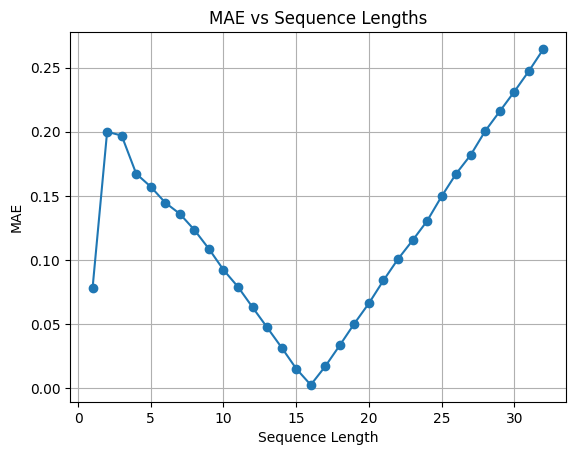

In [116]:
generalization(model)